# Hands-on example: mapping blood flow changes after MCAO (laser speckle data)

## Goals:
  - load MLF data
  - crop the area of interest and save as another sequence
  - make a movie
  - display overall CBF dynamics with time
  - calculate relative changes in blood flow
  - map these relative changes and look for peri-ischaemic zones
  - make nice plots in the process

First, we need to load importand modules and set up some display details:

In [16]:
%pylab qt
style.use('ggplot')
# This is just a custom plot style

from scipy import ndimage

import pandas as pd

import os.path

from imfun import fseq, lib, ui
rcParams['image.aspect']='equal'
rcParams['image.origin']='upper'
rcParams['figure.facecolor']='w'

from matplotlib import animation
#reload(animation)
animation.writers.list()

from imfun import filt

from matplotlib import rc


def minute2ind(arr, dt):
    "for array (e.g. tranges) in minutes, return frame indices, assuming dt is in seconds"
    #for i in range(len(arr)):   
    return (arr*60/dt).astype(np.int)

def sec2ind(arr, dt):
    "for array (e.g. tranges) in sec, return frame indices, assuming dt is in seconds"
    #for i in range(len(arr)):   
    return (arr/dt).astype(np.int)

def minsec2mindec(arr):
    "for time in format min.sec, return min.dec eg. 2.30 = 2.50"
    return (int(arr) + ((arr % 1) / 0.6))

def ind2sec(arr, dt):
    "for array (e.g. tranges) in frame indices, return seconds, assuming dt is in seconds"
    return (arr*dt)

def ind2min(arr, dt):
    "for array (e.g. tranges) in frame indices, return minutes, assuming dt is in seconds"
    return int(arr * dt / 60)

def satisfies_keys(field, keys):
    """for each key check whether string `field` contains this key 
    if key is a string or any variants of the key if the key is a collection of strings"""
    res = True
    for key in keys:
        if isinstance(key, basestring):
            tmp = key in field
        else:
            tmp = np.any([(variant in field) for variant in key])
        res = res and tmp
        if not res: break
    return res

def smart_filter_columns(table, keys):
    if isinstance(table, pd.Series):
        index = table.index
    elif isinstance(table, pd.DataFrame):
        index = table.columns
    else:
        raise TypeError("Wrong table format") 
    cols = [c for c in index if satisfies_keys(c, keys)]
    return cols
            
#merge reps

def get_average_of_rep(serie):
    """find repeated stimulations in a pd.serie and return a serie 
    contaning the average of theese stimulations """
    roi_all = unique([c.split(':')[-1].strip() for c in x.columns])#['r01', 'r02', 'r03']
    freq_all = sorted(unique([c.split(':')[2].strip() for c in x.columns]), 
                            key=lambda s: int(s.split('Hz')[0])) #['1Hz', '2Hz', '3Hz', '5Hz', '10Hz']
    epo_all = unique([c.split(':')[0].strip() for c in x.columns]) #['epo1', 'epo2', 'epo3', 'epo4']
    average_results = pd.Series()    
    for roi in roi_all:
        for freq in freq_all:
            for epo in epo_all:
                test_rep = smart_filter_columns(serie, [roi, freq, epo])
                rep_n = len(test_rep)
                average = serie[test_rep].mean(axis=None, skipna=None, level=None, numeric_only=None)
                average_results[' : '.join((epo, freq, roi, 'rep_n=%d'%rep_n))] = average
    return average_results

def pixels2mm2(areas, pixel_size):
    "take a list of areas in number of pixels and converts them to mm^2"
    areas_mm2 = []
    for i in range(len(areas)):
        areas_mm2.append((np.sum(areas[i]) * (pixel_size ** 2)) / 1000000)
    return areas_mm2

def area_in_pixels(tranges, dt, level_of_interest):
    """take a list of frame sequenses(minutes), time between frames(s) and a tuple with the level of interest(%). 
    it returns a list of areas in pixels"""
    changes_after = []
    areas = []
    for i in range(len(tranges)):
        changes_after.append(fs2.mean_frame(minute2ind(tranges[i], dt)))
    for i in range(len(changes_after)):
        areas.append((level_of_interest[0] < changes_after[i]) * (changes_after[i] < level_of_interest[1]))
    return areas

def montage(ims, ncols, mask=None, **kwargs):
    style.use('ggplot')
    sh = ims[0].shape
    nrows = int(np.ceil(len(ims)/float(ncols)))
    out_shape = nrows*sh[0],ncols*sh[1]
    out = np.zeros(out_shape)
    if mask is not None:
        out_mask = np.zeros(out_shape, np.bool)

    imrows, imcols = sh
    
    
    for k, m in enumerate(ims):
        row_i,col_i = imrows*(k/ncols), imcols*(k%ncols)
        _slice = (slice(row_i,row_i+imrows), slice(col_i,col_i+imcols))
        out[_slice] = m
        if mask is not None:
            if np.ndim(mask) > 2 and k < len(mask):
                out_mask[_slice] = mask[k]
            else:
                out_mask[_slice] = mask
    if mask is not None:
        out = ma.masked_where(out_mask, out)        
    imshow(out, **kwargs)
    [axvline(x, color='white') for x in range(imcols,out_shape[1], imcols)]
    [axhline(x, color='white') for x in range(imrows,out_shape[0], imrows)]
    r = Rectangle((0,0), 10, 1e3/pixel_size, color='yellow')
    gca().add_patch(r)
    setp(gca(), xticks=[],yticks=[],frame_on=False)
    tight_layout()
    return out

def extract_roi_data():
    agg = []
    stim_freqs = epochs[0]
    print stim_freqs
    tvec = arange(-baseline_horizon, afterstim_horizon)
    for epnum,epoch in enumerate(epochs[1:]):
        for repnum, rep in enumerate(epoch):
            for t0,freq in zip(rep, stim_freqs):
                print t0,freq
                arr = fs3[t0-baseline_horizon:t0+afterstim_horizon] # Array of frames we want to work on
                fs3_cut = fseq.open_seq(arr, meta=fs3.meta) # New, shorter frame sequence
                p3 = ui.Picker(fs3_cut, verbose=False)
                p3.start()
                p3.load_rois(data_path+ '041-funcmap-rois_mm.pickle')
                data = 100*array(p3.get_timeseries(normp=baseline_horizon))
                headers = [' : '.join(('epo%d'%(epnum+1), 'rep%d'%(repnum+1) ,'%dHz'%freq, tag)) for tag in p3.roi_tags()]
                x = pd.DataFrame({name:v for name,v in zip(headers, fs3)}, index=tvec)
                agg.append(x)
                close()
    return agg

from pandas import ExcelWriter

def save_xls(list_dfs, xls_path):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer,'%s' % sheet_labels[n])
    writer.save()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Step 0. Load the data (run always)


<font color='red'>Choose your path to the data.

This way you read the file names with system (non-python) `ls` command and convert it to a python variable

In [2]:
animal_name = 'm096'
#data_path = '/home/data/MLauritzen-group/data-for-seminar/'
data_path = '/Users/cfw958/Desktop/lsi/short_LSI/'+animal_name+'/'

#data_path = 'smb://sundcifs12.sund.root.ku.dk/INF/NEUROFYSIOLOGI/TransNeuro/Jonas C. Fordsmann/Data pHd/Live Image Measurement-m125a-JCF-2015.mlf'
# at the moment, I have the data in Dropbox right here
#data_path = './'

#files = !ls /Users/cfw958/Desktop/lsi/*125.mlf
x = data_path.replace(' ', '\ ') # This thing you have to do if the data path has whitespaces
files = !ls {x +'*'+animal_name+'*.mlf'} # this is equivalent to the above


<font color='red'>
  - Set ruler size in mm

  - The variable called 'of' (occlusion file) is the file number where you do the occlusion

  - put the number of files you want to merge (k=0 means 1 file)
  
  - Change the name so that it coresponde to the animal number
  
  - If you dont want the Improwed Lasso set improve_lasso to True
  
  - set limits for healthy, penumbra and core  as procentage of baseline before intervention (e.g. from 2o% to 50% of baseline would be (20, 50)


In [3]:
ruler_size = 3.55 # ruler size in mm (ruler  1 mm and gap between cranie edge where the gluebridge is = 3.55 mm) 
plastic_ruler_size = 1
of = 0 #Select the occlusion file (2nd, with 'b')
k = 0
improve_lasso = False
name_cropped = animal_name+'-cropped.h5'
healthy = (50, 2000)
penumbra = (20, 50)
core = (0, 20)
crop_frame = True

In [4]:
name = files[of]
print 'occlusion file: ', name

# Create frame sequence objects from a list for file names 
fslist = [fseq.open_seq(name) for name in files]
dt, units = fslist[0].meta['axes'][0]
frame_rate = float(fslist[0].meta.get('axes')[0][0])
print 'frame rate = ' + str(frame_rate) + ' FPS'
len(files)

occlusion file:  /Users/cfw958/Desktop/lsi/short_LSI/m096/Live Image Measurement-m096a-JCF-2015.mlf
frame rate = 1.0 FPS


1

<font color='red'>1) while cursor is over figure, press Shift to enable Lasso selector and right click and then rigth click and hold to draw around the area of interst
2) Draw line Roi

In [5]:
# Calculate average frame over first 60 seconds
mf = fslist[of].mean_frame(minute2ind(1, dt)) # First minute average

# Create a UI object and start it
p = ui.Picker(fslist[of]) #if you set a argument verbose = True inside brackets a manual get printet
p.start(mean_frame=mf, cmap='hot',vmax=1000) # I clip the values above 1000 for better vis.

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x104864c90>,
 <imfun.ui.Picker instance at 0x1043bf0e0>)

<font color='red'>If done before use the pixel_size according to output of this cell

In [36]:
# gets the length of a line roi put in a known distance to calculate pixel size

lengths = [r.length() for tag,r in p.roi_objs.items() if p.isLineROI(tag)]
#lengths_as_dict = {tag:r.length() for tag,r in p.roi_objs.items() if p.isLineROI(tag)}
#lengths_as_dict

#pixel_size = (ruler_size * 1000) / float(lengths[0]) # pixel size in um
#plastic_pixel_size = (plastic_ruler_size * 1000) / float(lengths[1]) # pixel size in um
# If done before use the following line to set pixel size according to output of this cell
pixel_size = 12.7589999218
plastic_pixel_size = 16.9812985828
print 'ruler length = ' + str(lengths) + ' pixels'
print 'pixel size = ' + str(pixel_size) + ' um'
print 'plastic pixel size = ' + str(plastic_pixel_size) + ' um'
len(lengths)
print fslist[0].meta
print fslist[0].shape()

ruler length = [] pixels
pixel size = 12.7589999218 um
plastic pixel size = 16.9812985828 um
{'axes': array([(1.0, 'sec'), (1.0, ''), (1.0, '')], 
      dtype=[('scale', '<f8'), ('units', 'S10')])}
(568, 760)


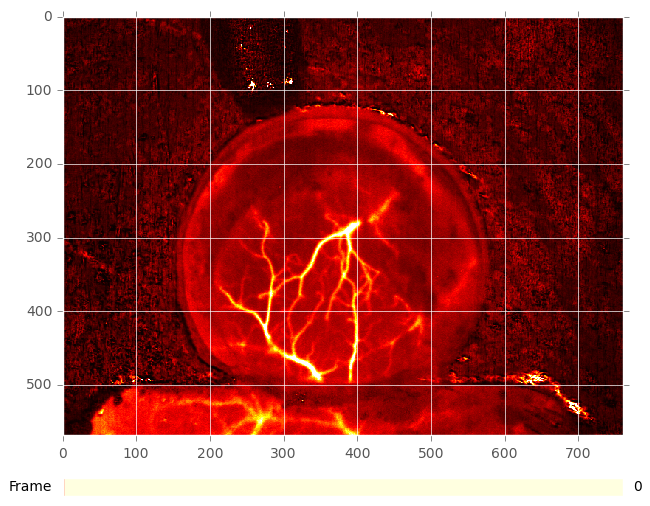

In [7]:
savefig(data_path + 'raw.svg')
gcf()

# Step 1. Cropping

<font color='red'>**If you already cropped the frame and saved the concatenated-and-cropped frame sequence, skip this and proceed to Step2**

In [16]:
if crop_frame:
    savefig(data_path + 'raw_figure.pdf') #alternatively .png .svg . eps
    gcf()

We can continue with it, but we can also try to improve this a little bit with active contours:

In [17]:
# Import morphsnakes module if it's installed, install and import it otherwise
if crop_frame:
    if improve_lasso:
        try:
            import morphsnakes
        except ImportError:
            print "Don't have morphsnakes, installing"
            !pip install https://github.com/abrazhe/morphsnakes/zipball/master
            import morphsnakes

In [18]:
if crop_frame:
    if improve_lasso:
        reload(morphsnakes)
        figure()
        snake = morphsnakes.MorphACWE(mf,smoothing=3, lambda2=1.5, levelset=p.pmask)
        snake.run(50) # Run 50 or less iterations of MACWE algorithm

        imshow(mf, cmap='gray',vmax=1000); colorbar()
        contour(p.pmask, levels=[0],  colors=['g']) # starting contour
        contour(snake.levelset, levels=[0],  colors=['r']) # end contour
        savefig(data_path + 'Improved lasso crop.pdf')
        gcf()

**Exercise**: change number of iterations and values for `smoothing`, `lambda1`, and `lambda2` arguments and see what happens.

## Clip the data
Simple solution (no need to load all data to memory), also demonstrates why fseq.fns is there: 

Too much white, eh? On the brigth side, we don't have to load all the frames to do this.

It seems better to through away all unnecessary data and save the cropped sequence to an HDF5 format, so working with it later will be faster:

In [19]:
if crop_frame:
    print help(lib.embedding)
    fs = fslist[of]

    #pmask = snake.levelset # Comment this line if you didn't do the snakes
    pmask = p.pmask # Uncomment this if you didn't do the snakes

    func = lambda f: ma.masked_where(pmask == 0, f*pmask)

    f = fs[10] # take 11th frame from frame sequence
    lib.group_maps([f, func(f), lib.embedding(func(f))[0]], 
               titles=['raw', 'masked', 'cropped'],
               show_ticks = True)
    savefig(data_path + 'raw, masked, cropped.svg')
gcf()

Help on function embedding in module imfun.lib:

embedding(arr, delarrp=True)
    Return an *embeding* of the non-zero portion of an array.
    
    Parameters:
      - `arr`: array
      - `delarrp`: predicate whether to delete the `arr`
    
    Returns tuple ``(out, (sh, slices))`` of:
        * out: array, which is a bounding box around non-zero elements of an input
          array
        * sh:  full shape of the input data
        * slices: a list of slices which define the bounding box

None


AttributeError: Picker instance has no attribute 'pmask'

Cropping box: [slice(240, 490, None), slice(209, 489, None)]
(250, 280) (250, 280)


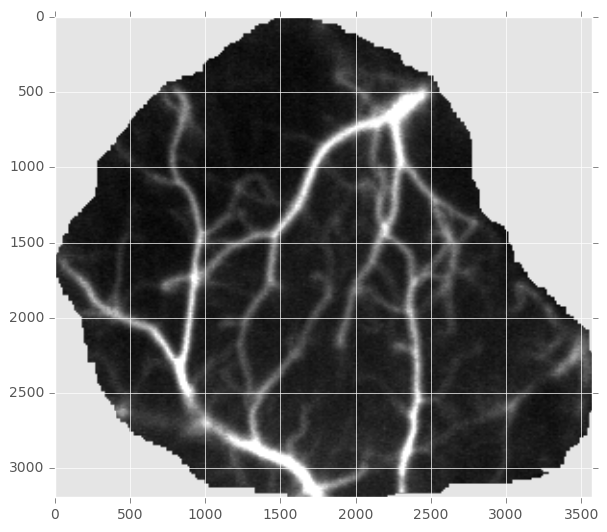

In [12]:
# we have to do embedding on the pmask, not each frame, to ensure the shape doesn't change
if crop_frame:
    _,(_,crop) = lib.embedding(pmask)

    print 'Cropping box:', crop

    fs = fslist[of]
    fs.fns = [lambda f: ma.masked_where(pmask==0, f*pmask), 
          lambda f: f[crop]]

    figure(10)
    imshow(fs.pipeline()(mf), vmax=1000,cmap='gray', extent = [0, (pixel_size * fs.shape()[1]), (pixel_size * fs.shape()[0]), 0])
    
    print fs[minute2ind(1, dt)].shape, fs.shape()
    savefig(data_path + 'cropping box.pdf')
gcf()

Apply the same processing pipline (a list of two functions applied to each frame in a sequence) to all loaded frame sequences (mlf files from the current experiment)

In [13]:
if crop_frame:
    pipeline = [lambda f: ma.masked_where(pmask==0, f*pmask), 
              lambda f: f[crop]]

    for seq in fslist:
        seq.fns = pipeline

In [14]:
# check that the pipeline makes sense for other frame sequences
if crop_frame:
    ui.Picker(fslist[k]).start(mean_frame=fslist[k].mean_frame(minute2ind(1, dt)), cmap='hot', vmax=1000,vmin=0)

connecting callbacks to picker


In [15]:
if crop_frame:
    reload(fseq)

Can't load OpenCV python bindings No module named cv2


This is the actual conversion function. It returns a name of the new file. May be it would be better if it returned the new sequence instead?

In [16]:
if crop_frame:
    name2 = fseq.fseq2h5(fslist, data_path + name_cropped)
    print name2

shape: [250 280]
/Users/cfw958/Desktop/lsi/short_LSI/m096/m096-cropped.h5


# Step 2. Resting CBF

Note you have to create a variable called name2 with the name of the processed frame sequence (the one that end with '.h5')

Let's check that everything worked as expected, if the sequences are not aligned: one sees a double-image. This proves that the camera sadly have been moved during the recordings

In [8]:
x = data_path.replace(' ', '\ ') # This thing you have to do if the data path has whitespaces
name2 = !ls {x + '*.h5'} 
print name2
fs2 = fseq.open_seq(name2[0])
fs2.meta

fs2.meta['axes'] = lib.alist_to_scale([(frame_rate, 's'), 
                                       (pixel_size, 'um'),
                                       (pixel_size, 'um')])

print fs2.meta
print fs2.shape()

['/Users/cfw958/Desktop/lsi/short_LSI/m096/m096-cropped.h5']
The file /Users/cfw958/Desktop/lsi/short_LSI/m096/m096-cropped.h5 has the following data sets: [u'data']
{'axes': array([(1.0, 's'), (12.7589999218, 'um'), (12.7589999218, 'um')], 
      dtype=[('scale', '<f8'), ('units', 'S10')])}
(250, 280)


There is nothing to merge


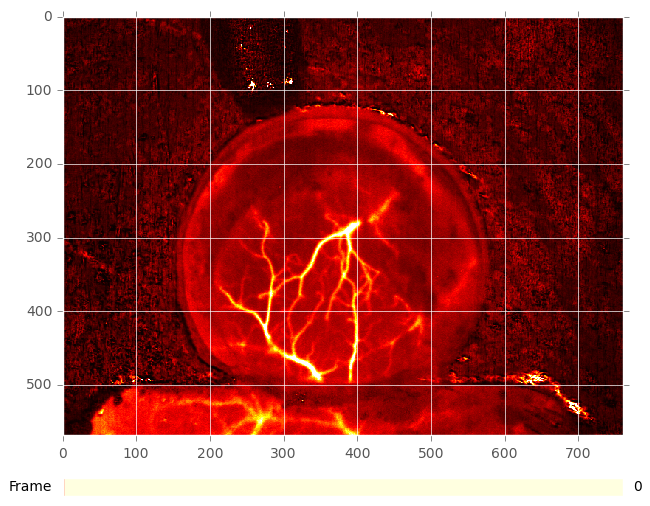

In [9]:
if len(fslist) > 1:   
    skip = len(fslist) and len(fslist[0]) or 0
    mf2 = fs2.mean_frame((skip, skip + minute2ind(1, dt)))
    p2 = ui.Picker(fs2); p2.start(mean_frame=mf2, cmap='gray',vmin=0, vmax=1000)    
else:
    print "There is nothing to merge"
gcf()

In [10]:
fs2[0]

from imfun import MLFImage

header, table = MLFImage.read_header(name)
print header

np.all([np.any(f>0) for f in fs2[:-1]])

Moor FLPI Live Image Data file V2.0


False

In [33]:
negative_test = pd.DataFrame(fs2[0])
#negative_test.to_excel(data_path+animal_name+' negative_test.xls')
print min(negative_test[256])
negative_test[256]
negative_test[256].describe

0.0


<bound method Series.describe of 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
      ... 
220    167
221    306
222    109
223    315
224    263
225    271
226    224
227    267
228    344
229    182
230    346
231    189
232    363
233    191
234    339
235      0
236      0
237    120
238      0
239      0
240      0
241      0
242      0
243      0
244      0
245      0
246      0
247      0
248      0
249      0
Name: 256, dtype: float64>

## Overall CBF dynamics

Small problem is, without going through the data, I don't know when MCAO was performed, so what to take as baseline and what time intervals to use for mapping. Let's find out by plotting interquartile range and the median of pixel intensities over time:

In [15]:
# Note I use list comprehesions all the time
fs2.fns = []
v = np.array([np.percentile(f[f>0], (25,50,75)) for f in fs2])

IndexError: cannot do a non-empty take from an empty axes.

In [ ]:
close('all')

In [ ]:
# time in minutes. If framerate is correctly set in fs2.meta, then
# fs2.frame_idx() returns time in seconds, we divide by 60 to convert to minutes
# if fs2.meta is not set, then frame_idx implies framerate is 1 Hz. This may be a problem
# if the framerate was different from 1 Hz.
t = fs2.frame_idx()/minute2ind(1, dt)

# borders between files
### 
fsborders = cumsum([len(fs) for fs in fslist]) #Run this if LSI files, if .h5 use next line with known values
#fsborders = [3310, 6659, 8922, 11344]
print 'Fsborders is:', fsborders

figure(figsize=(16,4)) # we want a looong figure

# fill_between -- well, to make a fill-between-two-lines-plot
fill_between(t, v[:,0], v[:,2], color='royalblue', alpha=0.5)

# and this is the median
plot(t,v[:,1], color='darkblue')

# put a green line at the merge points between the original files
for b in fsborders:
    axvline(b / minute2ind(1, dt), color='green', ls='--')

# Set x ticks to go every minute and limits for x axis
# gca() is the command to get the currently active axis
setp(gca(), xlim=(0, t[-1]), ylim=(0,800), xticks=arange(0,t[-1], 5)) # put ticks every 5 minutes

txt_par = dict(fontsize='large', horizontalalignment='right', transform=gca().transAxes)

text(0.95, 0.85, 'interquartile range', color='royalblue',**txt_par)
text(0.95, 0.75, 'median', color='darkblue', **txt_par)

xlabel('time, min',fontsize='large')
ylabel('AU',fontsize='large')

gcf()

**TODO**: add an interactive range picker

In [40]:
#description from log file
"""
Old animal
Purpose: Look for ACW after MCAO or Sham
… put tracheal tube , catheters, 2 cranies and  practice 2pm

Alternating between  
0,1 ml isotonic sodium chloride glukose I.P. and 200 mM sodium bicarbonate every half hour, early start 
Ca. 1 ml isotonic saline S.C.

HUGE subdural BLEEDING on medial part of brain form removing bone, blood stuck on brain 

LSI start 13:08
Start moving 4.00 into LSI file a
intervention (jcf) 6.30 into LSI file a(13.15)  MCAO  HUGE BLEEDING
stopped  moving 11.00 into LSI file a

Made well and coverglas on surgery table


loading angel 27.5 degrees with Changsi new method
loading looked ok but did not properly take up into cells..looked like SR101 in capilaries
no LFP spontaneous and evoked

Photo 
No Movies 
1 Stim Movies (no responses)
1 z stack

Bad  image quality to begin, Used full lut spectrum and high power and gain 

used  green and red channel (filter cube setting 3)
No perfusion
 
"""

'\nAlternating between  \n0,1 ml isotonic sodium chloride glukose I.P. and 200 mM sodium bicarbonate every half hour, early start \nCa. 1 ml isotonic saline S.C.\n\nLSI start 13:14\nStart moving 5.00 into LSI file a\nintervention (jcf) 5.50 into LSI file a(13.20) MCAO  Perfect\nstopped  moving 8.05 into LSI file a\n\nMade well and coverglas on surgery table\n\nPulse-oxymeter on/off : ?\n\nloading angel 27.5 degrees \nok loading x2\nno LFP spontaneous and evoked\n\nPhoto HD 100,  150, 200, 210 min after\nMovies 100, 150, 170, 210 min after, 366 x 366um, 256 x 256 px, 10 min, ca. 100 um deep \n\nStim Movies 120,  140 min after (no responses)\n\nGood image quality to begin, Used full lut spectrum and high power and gain (no clear bleaching)\n\nused  green and red channel (filter cube setting 3)\nlate perfusion\n \n'

spike file
<img src="spike overview m125.tiff">

<font color='red'> 
Here you should put;
 - Occlusion time in minutes and sec(e.g. 3min 30sec = 3.30)
 - Baseline of 2 min and intervals of 2 min that you want to analyse. Format (1, 3) means from first min to third min of movie.
 - You can use fsboarder if useful. Remember to avoid stimulations.

In [41]:
#occlusion_time_input = 16.45 # occlusion time in format min.sec (if more movies are merged you can use fsboarders)
#occlusion_time= ind2min(fsborders[0], dt) + minsec2mindec(07.00) #if more movies are merged you can use fsboarders stil in format min.sec

#occlusion_time=minsec2mindec(6.50)
occlusion_time = 6.88

#translate occlusion time to decimal
#occlusion_time = minsec2mindec(occlusion_time_input)#int(occlusion_time_input) + ((occlusion_time_input % 1) / 0.60) # occlusion time in minutes (decimal), dont change

#set tranges
#before_stim = (1, 3)
baseline = (0, 2)#(fsborders[0]/60.-2, fsborders[0]/60.+0) # # min 
interval_1 = (8, 10) #(occlusion_time + 0, occlusion_time + 2)#(occlusion_time, occlusion_time + 2) # min
interval_2 = (15, 17) #(occlusion_time + 8, occlusion_time + 10)#(fsborders[1]/60.-2, fsborders[1]/60.+0) #(occlusion_time + 8, occlusion_time + 10) #min
#interval_3 = (125, 127) #(fsborders[2]/60.-2, fsborders[2]/60.+0) #(fsborders[1]/60.+11, fsborders[1]/60.+13) # min
#interval_4 = (136, 138) #((ind2min(fsborders[2], dt) + minsec2mindec(05.00)), (ind2min(fsborders[2], dt) + minsec2mindec(07.00)))

#makes array of tranges (dont change)
tranges_min = np.array([baseline, interval_1, interval_2]) #, interval_3, interval_4])
tranges_ind = minute2ind(tranges_min, dt)
#reperfusion_time = 42.63

step 2 basic ends here

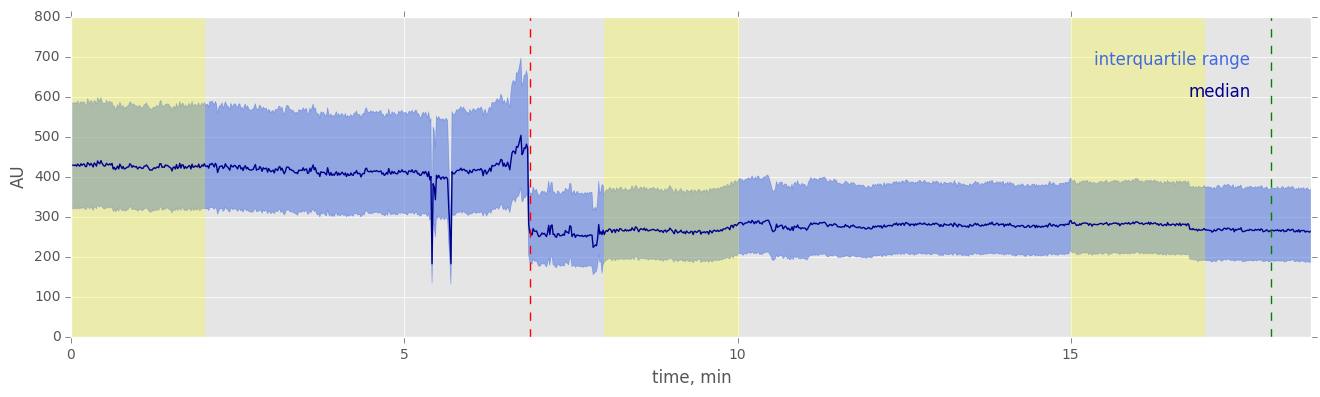

In [42]:
#mark occlusion time
axvline(occlusion_time,  color='r', ls='--')
#axvline(reperfusion_time,  color='r', ls='--')

# Show them on the graph:
for r in tranges_min:
    axvspan(*r, alpha=0.25, color='yellow')

draw()
gcf()

In [43]:
base_frame = fs2.mean_frame(tranges_ind[0]) # time-averaged frame over first of tranges

### <font color='blue'>Could be nice to be able to make a movie where 'no changes' shown as grey scale and changes above SD or 10 % shown as color scale)

Create a demonstration movie from the new frame sequence:
<font color='red'> 
Here you should put;
 - movie name
 - movie start
 - movie stop
 - set make movie to true if you want to make the movie
    

In [45]:
movie_name = animal_name+'-Sham x20.mp4'
movie_start = 5 #time in minutes
movie_stop = 8 #time in minutes
fps = 20
make_movie = True

Don't run the following so far, as your system lacks `mencoder` or `avconv` and will instead try to create 8K images in your current folder.

In [46]:
if make_movie:
    fs2.export_movie_anim(data_path + movie_name, fig_size=(6,8), fps=fps, start = minute2ind(movie_start, dt), 
                          stop = minute2ind(movie_stop, dt), writer='ffmpeg', 
                          codec='h264',
                          cmap='hot',
                          vmin=0,vmax=1000)

## Calculate normalized CBF values in a lazy way

In [47]:
fs2.fns = [lambda f: np.where(base_frame>0, (100.*f)/base_frame, 0), 
           lambda f: ma.masked_where(base_frame <= 0, f)]
v = np.array([np.percentile(f[f>0], (25,50,75)) for f in fs2.frames()])

Now, show the new data:

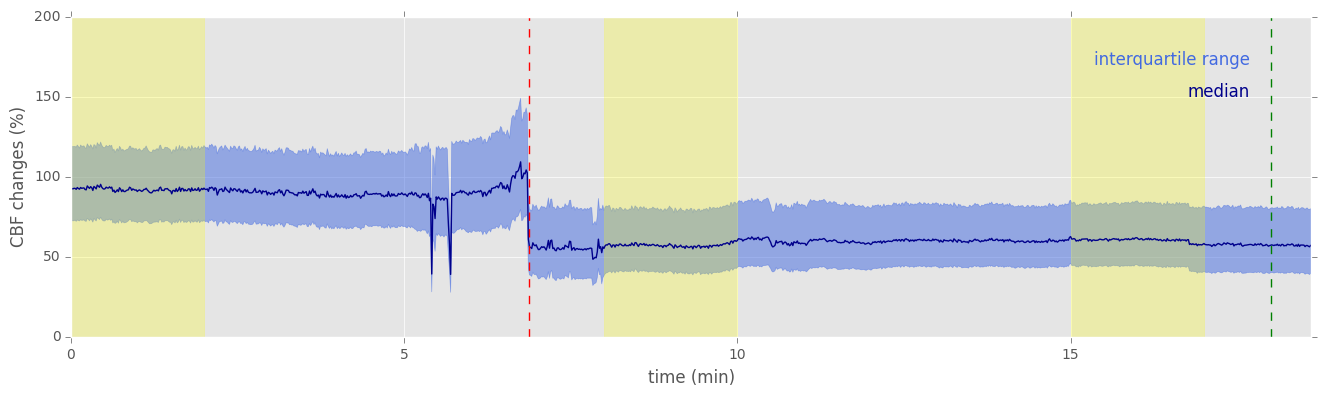

In [48]:
fig_handle = figure(figsize=(16,4)) # we want a looong figure

# fill_between -- well, to make a fill-between-two-lines-plot
fill_between(t, v[:,0], v[:,2], color='royalblue', alpha=0.5)

# and this is the median
plot(t,v[:,1], color='darkblue')

# average
#plot(t, frame_average, color = 'deeppink')

# put a green line at the merge points between the original files
for b in fsborders:
    axvline(b / minute2ind(1, dt), color='green', ls='--')

# Set x ticks to go every minute and limits for x axis
# gca() is the command to get the currently active axis
setp(gca(), xlim=(0, t[-1]), ylim=(0,200), xticks=arange(0,t[-1], 5)) # put ticks every 5 minutes

txt_par = dict(fontsize='large', horizontalalignment='right', transform=gca().transAxes)

text(0.95, 0.85, 'interquartile range', color='royalblue',**txt_par)
text(0.95, 0.75, 'median', color='darkblue', **txt_par)

xlabel('time (min)',fontsize='large')
ylabel('CBF changes (%)',fontsize='large')
#mark occlusion time
axvline(occlusion_time,  color='r', ls='--')
#axvline(reperfusion_time,  color='r', ls='--')

# Show them on the graph:
for r in tranges_min:
    axvspan(*r, alpha=0.25, color='yellow')
    
draw()

savefig(data_path + 'normalized_timecourse_figure.pdf') #alternatively .png .svg . eps

fig_handle

In [49]:
changes = []
for trange in tranges_ind:
    changes.append(fs2.mean_frame(trange))

penumbra_areas_mask = []
for change in changes:
    penumbra_areas_mask.append((penumbra[0] < change) * (change < penumbra[1]))
    
core_areas_mask = []
for change in changes:
    core_areas_mask.append((core[0] < change) * (change < core[1]))
    
p2 = ui.Picker(fs2); p2.start(cmap='jet', vmin=10, vmax=110, mean_frame = changes[1])

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x11a91d890>,
 <imfun.ui.Picker instance at 0x11a2a8908>)

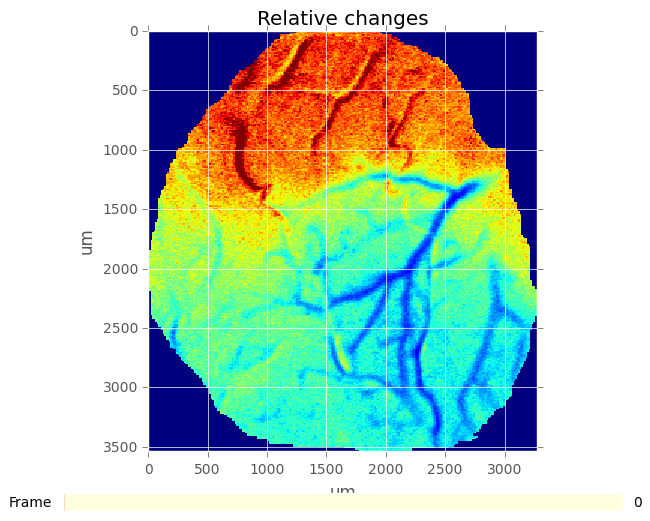

In [50]:
p2.fig.axes[0].set_title('Relative changes')
savefig(data_path + 'relative_changes_figure.pdf') #alternatively .png .svg . eps
gcf()

Lets calculate size of the different areas in mm^2

In [51]:
# Calulating area of craniotomy in um^2
craniotomy_area = area_in_pixels([tranges_min[0]], dt, (0, 2000))

# Calulating craniotomy area in um^2
craniotomy_area_mm2 = pixels2mm2(craniotomy_area, pixel_size)

print 'size craniotomy area = ' + str(craniotomy_area_mm2) + ' mm^2'

#mask penumbra for each of the tranges
penumbra_areas = area_in_pixels(tranges_min, dt, penumbra)

# Calulating areas of penumbra in um^2
penumbra_areas_mm2 = pixels2mm2(penumbra_areas, pixel_size)

print 'size penumbra areas = ' + str(penumbra_areas_mm2) + ' mm^2'

#mask core for each of the tranges
core_areas = area_in_pixels(tranges_min, dt, core)

# Calulating areas of core in um^2
core_areas_mm2 = pixels2mm2(core_areas, pixel_size)

print 'size core areas = ' + str(core_areas_mm2) + ' mm^2'

#mask healthy for each of the tranges
healthy_areas = area_in_pixels(tranges_min, dt, healthy)

# Calulating areas of healthy in um^2
healthy_areas_mm2 = pixels2mm2(healthy_areas, pixel_size)

print 'size healthy areas = ' + str(healthy_areas_mm2) + ' mm^2'

size craniotomy area = [9.0270786016088405] mm^2
size penumbra areas = [0.0, 2.3235108121383643, 1.277503423220139] mm^2
size core areas = [0.0, 0.0, 0.0007917101036317173] mm^2
size healthy areas = [9.0270786016088405, 6.7034094474497499, 7.7487834682850698] mm^2


In [52]:
#make dataframe with all area data
time_lab = []
for r in tranges_min:
    time_lab.append("%0.0f to %0.0f min"%tuple(r - occlusion_time))

print time_lab

area_data = pd.DataFrame({'whole cranie (mm^2)':craniotomy_area_mm2, 'healthy (mm^2)':healthy_areas_mm2, 
                                       'penumbra (mm^2)':penumbra_areas_mm2, 
                                       'core (mm^2)':core_areas_mm2},
                                         index = time_lab)

area_data

['-7 to -5 min', '1 to 3 min', '8 to 10 min']


,core (mm^2),healthy (mm^2),penumbra (mm^2),whole cranie (mm^2)
-7 to -5 min,0.000000,9.027079,0.000000,9.027079
1 to 3 min,0.000000,6.703409,2.323511,9.027079
8 to 10 min,0.000792,7.748783,1.277503,9.027079


In [53]:
#normalise area results to whole cranie
area_data_norm = area_data / area_data.iloc[0]['whole cranie (mm^2)'] * 100

# renaming column names
area_data_norm.columns = ['core (%)', 'healthy (%)', 'penumbra (%)', 'whole cranie (%)']
area_data_norm

,core (%),healthy (%),penumbra (%),whole cranie (%)
-7 to -5 min,0.00000,100.000000,0.000000,100
1 to 3 min,0.00000,74.258902,25.739344,100
8 to 10 min,0.00877,85.839326,14.151903,100


In [54]:
#area_data_norm.rename(columns={'$a': 'a', '$b': 'b'}, inplace=True)
#area_data_norm

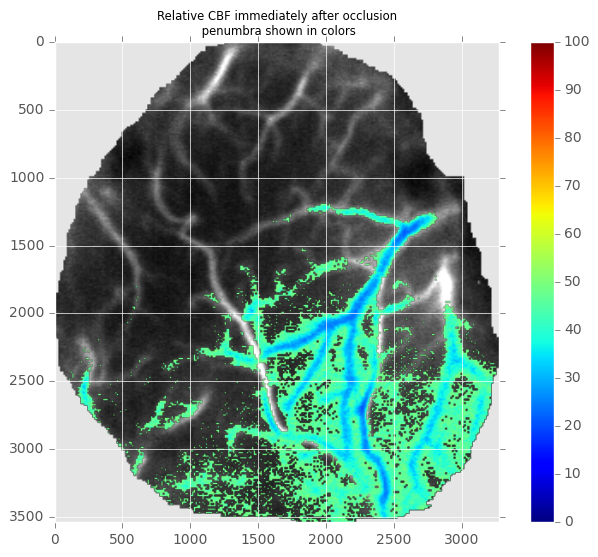

In [55]:
figure()

penumbra_area = (penumbra[0] < changes[1]) * (changes[1] < penumbra[1])

imshow(ma.masked_less_equal(base_frame, 0), cmap='gray',vmax=1000, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0])
imshow(ma.masked_where(-penumbra_area, changes[1]), vmin=0, vmax=100, aspect = 'equal', extent = [0, (pixel_size * fs2.shape()[1]),
                                                                             (pixel_size * fs2.shape()[0]), 0]); colorbar()
title('Relative CBF immediately after occlusion\n penumbra shown in colors',size='small')
savefig(data_path + 'relative_changes_masked_figure.pdf') #alternatively .png .svg . eps
gcf()

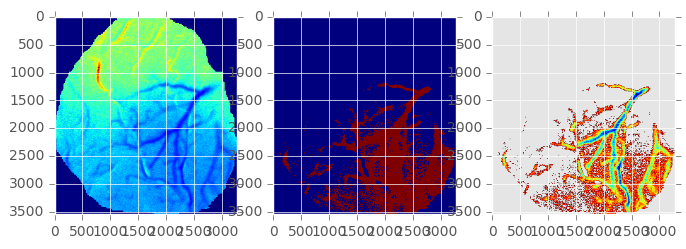

In [56]:
fs2.shape()
ma.masked_where(-penumbra_area, changes[1])

figure()
subplot(1,3,1)
imshow(changes[1], extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])

subplot(1,3,2)
imshow(penumbra_area, extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])

subplot(1,3,3)
imshow(ma.masked_where(-penumbra_area, changes[1]), extent = [0, (pixel_size * fs2.shape()[1]), (pixel_size * fs2.shape()[0]), 0])
gcf()

In [57]:
close ('all')

## Time-averaged maps

Again, I use list comprehensions. Now In also use a `map` function to apply my masking to each new array:

In [58]:
maps = map(fs2.fns[1], [fs2[x:y].mean(axis=0) for x,y in tranges_ind])
masks = [ma.masked_where((abs(m-100)<50)+(base_frame==0), m) for m in maps]

To show all maps together, we can define a convenience function, I'll call it `montage`:

**TODO** `montage` should be merged into `imfun.lib` in the future

Let's apply it and see what happens:

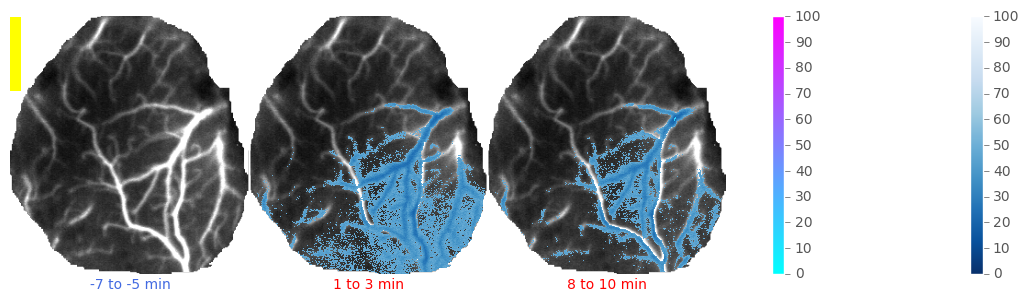

In [59]:
figure(figsize=(12,3))
neg_penumbra_areas_mask = [-x for x in penumbra_areas_mask]
neg_core_areas_mask = [-x for x in core_areas_mask]

bx = montage([base_frame]*len(maps),len(maps),mask=base_frame<=0,vmax=1000,cmap='gray')

x = montage(maps,len(maps),mask=(neg_penumbra_areas_mask)+(base_frame<=0),
            vmin = 0, vmax=100,interpolation='nearest', cmap = cm.Blues_r) #cm.Blues_r
colorbar()

cx = montage(maps,len(maps),mask=(neg_core_areas_mask)+(base_frame<=0),vmin = 0, vmax=100,interpolation='nearest', 
             cmap = 'cool')
colorbar()


h,w = maps[0].shape

for k,r in enumerate(tranges_min):
    color = k and 'red' or 'royalblue'
    text((k+0.5)*w, h+15, "%0.0f to %0.0f min"%tuple(r - occlusion_time), 
         color=color, horizontalalignment='center')

savefig(data_path + 'Time-averaged maps_figure.pdf') #alternatively .png .svg . eps    
gcf()

And as filled contours at user-specified levels:

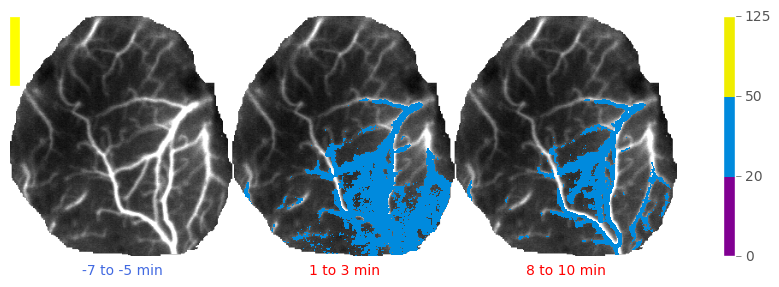

In [60]:

levels = [core[0], penumbra[0], penumbra[1], 125] # This value might be somewhat crazy
#extent = [0, (pixel_size * fs2.shape()[1]),(pixel_size * fs2.shape()[0]), 0]

f=figure(figsize=(12,3));
imshow(bx, cmap='gray', vmax=1000)

contourf(x, levels=levels, cmap='spectral'); #colorbar()
#x = montage(maps,len(maps),mask=(-penumbra_area)+(base_frame<=0),vmin = 0, vmax=150,interpolation='nearest'); colorbar()

contourf(cx, levels=levels, cmap='spectral'); colorbar()

setp(gca(), aspect='equal', xticks=[], yticks=[], frame_on=False)

h,w = maps[0].shape

for k,r in enumerate(tranges_min):
    color = k and 'red' or 'royalblue'
    text((k+0.5)*w, h+20, "%0.0f to %0.0f min"%tuple(r - occlusion_time), 
         color=color, horizontalalignment='center')

r = Rectangle((0,0), 10, 1e3/pixel_size, color='yellow')
gca().add_patch(r)

savefig(data_path + 'Time-averaged maps_sharp_figure.pdf') #alternatively .png .svg . eps
gcf()

** Exercises: **
  2. Export relative changes as a movie
  3. How woudl you overlay the now-cropped mask on top of the full frame from the frame sequence we started with?

In [61]:
close('all')

In [62]:
print data_path
name3 = !ls {data_path + '*.h5'} 
print name3
fs3 = fseq.open_seq(name3[0])
fs3.meta['axes'] = lib.alist_to_scale([(frame_rate, 's'), (pixel_size, 'um'), (pixel_size, 'um')])



/Users/cfw958/Desktop/lsi/short_LSI/m085/
['/Users/cfw958/Desktop/lsi/short_LSI/m085/m085-cropped.h5']
The file /Users/cfw958/Desktop/lsi/short_LSI/m085/m085-cropped.h5 has the following data sets: [u'data']


In [63]:
p3 = ui.Picker(fs3)
p3.start(mean_frame = base_frame, vmax = 1000)

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x119c86e10>,
 <imfun.ui.Picker instance at 0x11b3d1ea8>)

<font color='red'>Place rois in the functional area. two in penumbra and one in healthy tissue

In [64]:
if os.path.isfile(data_path+ animal_name+'-funcmap-rois.pickle'):
    p3.load_rois(data_path+ animal_name+'-funcmap-rois.pickle')
else:
    print 'place rois !!!'

place rois !!!


<font color='red'>If you want to save another version of rois change data file name or reposition in picker

Saved ROIs to  /Users/cfw958/Desktop/lsi/short_LSI/m085/m085-funcmap-rois.pickle


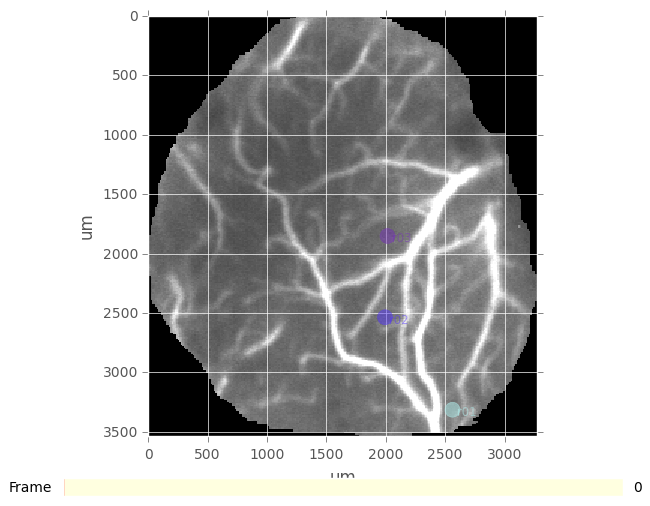

In [65]:
rois = p3.export_rois(data_path + animal_name+'-funcmap-rois.pickle') #
roi_file = animal_name+'-funcmap-rois.pickle'
savefig(data_path + 'roi_placement_figure.pdf')
gcf()

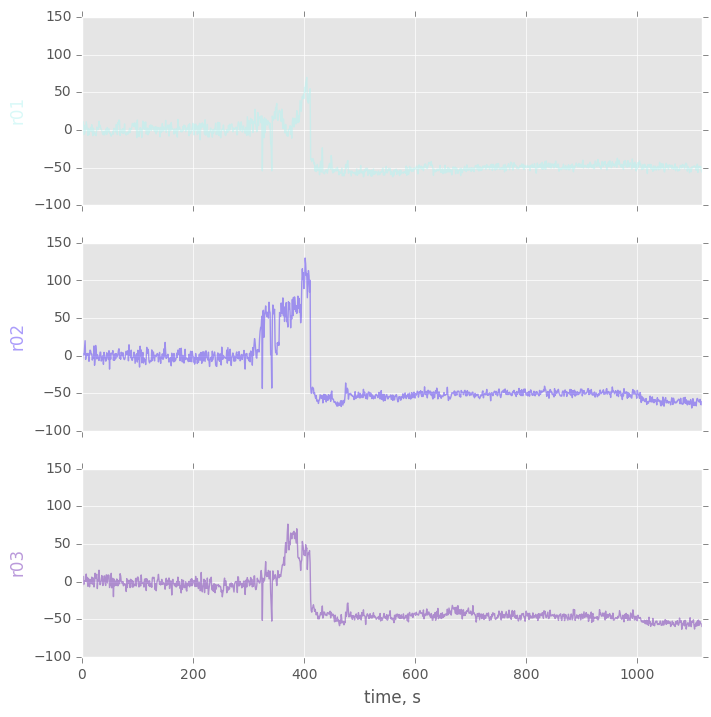

In [66]:
p3.show_zview(normp = lambda v: 100*(v/mean(1.0*v[:sec2ind(120, dt)]) -1)) # Show normalized time series from ROIs
f = gcf()
f.set_size_inches((8,8))
savefig(data_path + 'roi_test_figure.pdf')
f

In [67]:
#resting CBF in ROIS
#take average of trange for each ROI and normalize to trange_min[0]

p4 = ui.Picker(fs3, verbose=False)
p4.start(mean_frame = base_frame, vmax = 1000)
p4.load_rois(data_path + roi_file)    

connecting callbacks to picker


In [68]:
data = p4.get_timeseries()

resting_cbf = pd.DataFrame()
for roi in range(len(rois)):
    time_series = pd.Series()
    mean_resting = []
    for trange in range(len(tranges_ind)):
        resting = (data[roi][tranges_ind[trange][0] : tranges_ind[trange][1]])
        mean_resting.append(resting.mean())
        norm_resting = 100 * mean_resting[trange] / mean_resting[0] 
        x = pd.Series(norm_resting, index = [time_lab[trange]]) 
        x.name = p3.roi_tags()[roi]
        time_series = time_series.append(x)
    resting_cbf = resting_cbf.append(time_series)
resting_cbf.to_csv(data_path+'resting CBF norm.csv')

resting_cbf = resting_cbf[time_lab]
resting_cbf.reindex([p3.roi_tags()])
resting_cbf

,-7 to -5 min,1 to 3 min,8 to 10 min
r01,100,44.189959,53.224126
r03,100,46.180832,49.236281
r02,100,53.618876,52.769916


In [69]:
#Looking for PIDS
p5 = ui.Picker(fs3)
p5.start(mean_frame = base_frame, vmax = 1000)

connecting callbacks to picker


(<matplotlib.axes._subplots.AxesSubplot at 0x119b36090>,
 <imfun.ui.Picker instance at 0x11ee0fb00>)

In [70]:
if os.path.isfile(data_path+ animal_name+'-pid-funcmap-rois.pickle'):
    p5.load_rois(data_path+ animal_name+'-pid-funcmap-rois.pickle')
else:
    print 'place rois !!!'

place rois !!!


Saved ROIs to  /Users/cfw958/Desktop/lsi/short_LSI/m085/m085-pid-funcmap-rois.pickle


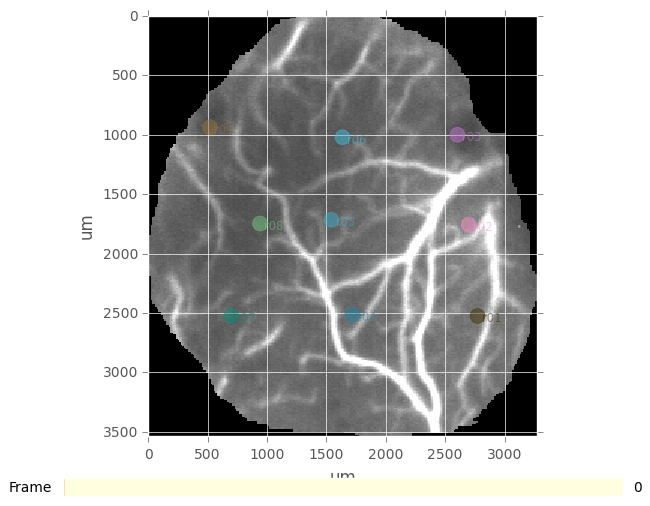

In [71]:
rois = p5.export_rois(data_path + animal_name+'-pid-funcmap-rois.pickle') #
roi_file_pid = animal_name+'-pid-funcmap-rois.pickle'
savefig(data_path + 'roi_pid_placement_figure.pdf')
gcf()

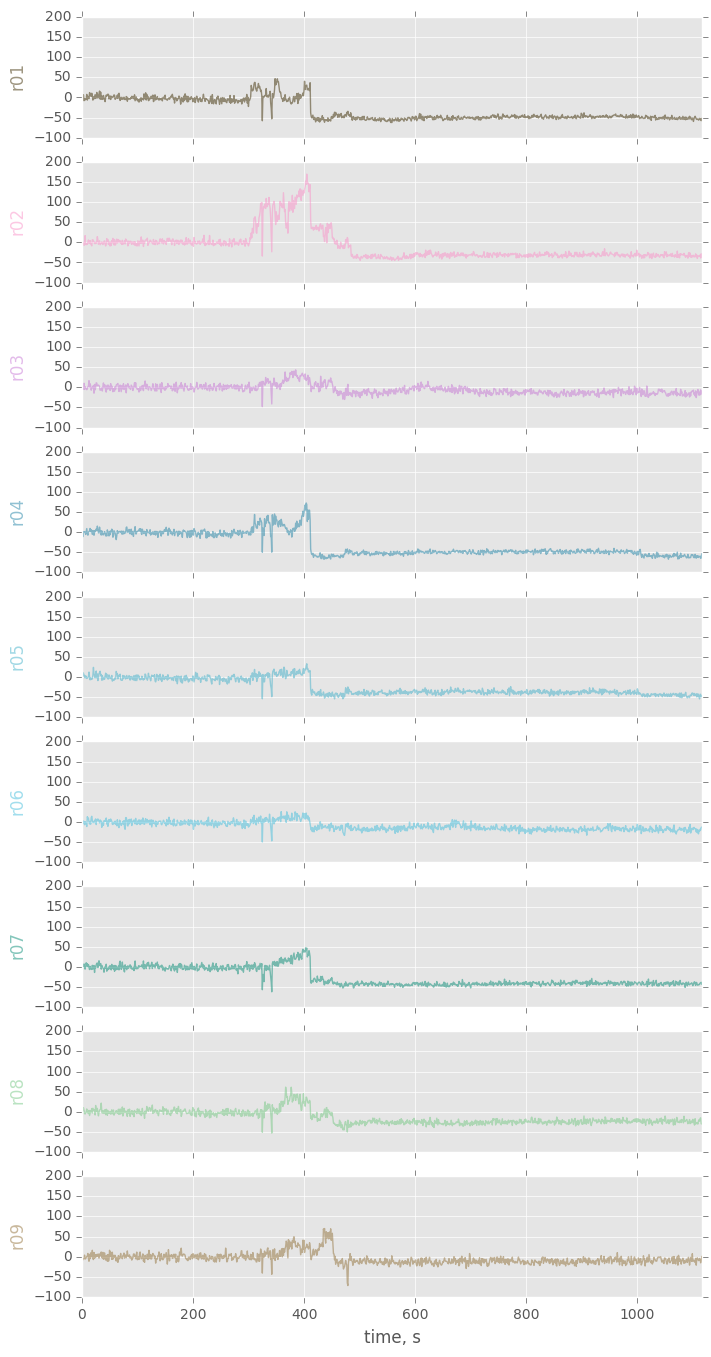

In [72]:
p5.show_zview(normp = lambda v: 100*(v/mean(1.0*v[:sec2ind(120, dt)]) -1)) # Show normalized time series from ROIs
f = gcf()
f.set_size_inches((8,16))
savefig(data_path + 'roi_pid_test_figure.pdf')
f

In [73]:
from pandas import ExcelWriter

def save_xls(list_dfs, xls_path):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer,'%s' % sheet_labels[n])
    writer.save()

data_list = [area_data, area_data_norm, resting_cbf]
sheet_labels = ['area_data', 'area_data_norm', 'resting_cbf']

save_xls(data_list, data_path+animal_name+' all data.xls' )


In [74]:
close('all')